# Import libraries

In [2]:
import serial
import RPi.GPIO as GPIO
import os
import math
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# Helper Functions

In [3]:
def capture_recyc(f="0"):
    ser.write(b"green1\n")
    time.sleep(2)
    os.system("fswebcam -d/dev/video0 -r 288x288 /home/pi/Downloads/ControlingArduino/recyc_f"+f+".jpg --no-banner")
    ser.write(b"off\n")
    
def capture_compos(f="0"):
    ser.write(b"green2\n")
    time.sleep(2)
    os.system("fswebcam -d/dev/video2 -r 288x288 /home/pi/Downloads/ControlingArduino/compos_f"+f+".jpg --no-banner")
    ser.write(b"off\n")

    
def get_imgs(imgName1 = "compos_f0", imgName2="recyc_f0"):
    img1 = cv2.imread(imgName1+'.jpg') 
    img2 = cv2.imread(imgName2+'.jpg') 
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    return img1, img2

    
def show_imgs(imgName1 = "compos_f0", imgName2="recyc_f0"):
    titles = [imgName1+' Camera', imgName2+' Camera']
    img1, img2 = get_imgs(imgName1 , imgName2)
    images = [img1,img2]
    for i in range(2):
        plt.subplot(1,2,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
        #plt.figsize = (228,228)
    plt.show()    

def imgae_diff(imgf, img0, thresh = 0):
    imgf = np.array(imgf)
    img0 = np.array(img0)

    
    f_shape = np.shape(imgf)
    
    imgf_flatten = imgf.flatten()
    img0_flatten = img0.flatten()
    
    num_pixels_changed =  0
    
    for i in range(len(imgf_flatten)):
        if (imgf_flatten[i] >= img0_flatten[i]-thresh) and (imgf_flatten[i] <= img0_flatten[i]+thresh):
            imgf_flatten[i] = 255
        else:
            num_pixels_changed += 1
    return np.reshape(imgf_flatten, (f_shape)), num_pixels_changed




def dominant_colar_channel(img, lower_b=50, upper_b=200):
    summ = 0
    counter = 1
    im = img.flatten()
    for i in range(len(im)):
        if((im[i]>lower_b)and(im[i]<upper_b)):
            summ += im[i]
            counter += 1
    
    return int(summ/counter)

def get_average_color(img, lower_b=50, upper_b=200):
    r = dominant_colar_channel(img[0])
    print(r)
    g = dominant_colar_channel(img[1])
    b = dominant_colar_channel(img[2])
    rgb_result = (r,g,b)
    return rgb_result

def disconnect_img(img, thresh=50):
    img = np.array(img)

    
    f_shape = np.shape(img)
    
    img_flatten = img.flatten()
    
    for i in range(1, len(img_flatten)-1):

        if img_flatten[i-1]  >= 255-thresh and img_flatten[i+1] >= 255-thresh:
            img_flatten[i] = img_flatten[i-1]
    return np.reshape(img_flatten, (f_shape))

# video0 for RECY
# video2 for COMP

# command to check cameras is /dev/video*

## Changing the RGB Value to the COLOR name and then finding the Material

In [7]:
Black    = (0,0,0)
White    = (255,255,255)
Red      = (255,0,0)
Green    = (0,255,0)
Blue     = (0,0,255)
Yellow   = (255,255,0)
Magenta  = (255,0,255)
Cyan     = (0,255,255)
    
Colors_To_Check = [Black    , White   , Red       , Green     , Blue     , Yellow    , Magenta   , Cyan    ]
Colors_Names    = ['Black'  , 'White' , 'Red'     , 'Green'   , 'Blue'   , 'Yellow'  , 'Magenta' , 'Cyan'  ] 
MaterialofColor = ["plastic", "paper" , "composit", "composit", "plastic", "composit","plastic","plastic"]


eps = 1

def compute_similarity_scores(c1,c2):
    return ()
    s
    d= math.sqrt(math.pow((c2[0]-c1[0]),2)+math.pow((c2[1]-c1[1]),2)+math.pow((c2[2]-c1[2]),2))
    return d

def distance_colors(c1, c2):
    return math.sqrt(math.pow((c2[0]-c1[0]),2)+math.pow((c2[1]-c1[1]),2)+math.pow((c2[2]-c1[2]),2))

def percentage_colors(c1, c2):
    return 1- distance_colors(c1, c2)/math.sqrt(3*(255*255))
    
def convert_rgb_to_name(rgb_tuple, Colors_To_Check=Colors_To_Check, Colors_Names=Colors_Names, MaterialofColor=MaterialofColor):
    perc, ind = 0, 0
    for i in range(len(Colors_To_Check)):
        perc_temp = percentage_colors(rgb_tuple, Colors_To_Check[i])
        if(perc_temp > perc):
            perc = perc_temp
            ind = i
    
    print("Closest Match : ", Colors_Names[ind], " with accuracy of ",perc*100,"%")
        
    return  MaterialofColor[ind]



from twilio.rest import Client
def send_sms(message='You Gained a point', reciever='+your phone number', sender_ph = 'provided number')
    account_sid = 'your account_sid'
    auth_token = 'your auth_token'


    # Find your Account SID and Auth Token at twilio.com/console
    # and set the environment variables. See http://twil.io/secure

    client = Client(account_sid, auth_token)

    message = client.messages.create(
                                  body=message,
                                  from_=sender_ph,
                                  to=reciever
                              )

    print(message.sid)

In [8]:
def process_trash(typ="compos"):
    """
    type should be comp or recyc
    """
    #First we capture/update the image
    if (typ == "compos"):
        capture_compos(f="1")
        time.sleep(3)
    elif(typ == "recyc"):
        capture_recyc(f="1")
        time.sleep(2)
        
    # frame 0 will be captured in advance
    #show_imgs(typ+"_f0.jpg",typ+"_f1.jpg")
    print(typ)
    img1, img2 = get_imgs(typ+"_f0",typ+"_f1")
    
    # getting unnacurate image of the changed pixels
    ff, num_pixels_changed = imgae_diff(img1, img2, 60)
    
    #Getting the mask
    ret,mymask = cv2.threshold(ff,60,255,cv2.THRESH_BINARY)
    mymask = cv2.cvtColor(mymask, cv2.COLOR_BGR2GRAY)
    
    # Isolating the changed pixels
    fg = cv2.bitwise_or(img1,img1,mask=255-mymask)
    fg=fg+255
    
    # Getting the material type
    dom = get_average_color(fg)
    material = convert_rgb_to_name(dom)
    
    cv2.imwrite(typ+"_f0.jpg", img2)
    
    if (num_pixels_changed<300):
        print("No items were added to the TrashCan")
        return 2
    
    if (material == "composit") and (typ=="compos"):
        return True
    else:
        return False


In [18]:
from gtts import gTTS
import os
import vlc
import time

def say_this(name='gained'):
    
    t = 'You '+name+' a Point'
    tts = gTTS(text=t, lang='en')
    tts.save(name+".mp3")
    #os.system("mpg321 temp.mp3")

    p = vlc.MediaPlayer(name+".mp3")
    p.play()
    time.sleep(2)
    
say_this('lost')
say_this('gained')


[025e1008] vlcpulse audio output error: PulseAudio server connection failure: Connection refused
[025dc350] vlcpulse audio output error: PulseAudio server connection failure: Connection refused


## Sending a post request to add 1 point

In [3]:
import requests

def add_point():
    url = 'https://pubelle.herokuapp.com/api/addpoints/1/'
    myobj = {'': ''}

    x = requests.post(url, data = myobj)

    print(x.text)

In [11]:
# red2 and green2 are for COMPOS which is M1
# red1 and green1 are for RECYC  which is M2

try:
    ser=serial.Serial("/dev/ttyUSB0",9600)  
except:
    try:
        ser=serial.Serial("/dev/ttyUSB1",9600) 
    except:
        ser=serial.Serial("/dev/ttyUSB2",9600) 
    
ser.baudrate=9600
#ser.flush()
GPIO.setmode(GPIO.BOARD) #BOARD

# Getting the default frame on startup
capture_compos(f="0")
time.sleep(2)

capture_recyc(f="0")
time.sleep(2)

capture_compos(f="1")
time.sleep(2)

capture_recyc(f="1")
time.sleep(2)

#while True:
    # red1 gives green in b1 and red in b2
    
    # red2 gives green in b1
    # green2 gives red in b1

while True:
    read_ser=ser.readline()
    read_ser = read_ser.decode()
    #read_ser = (read_ser).split('\"r')[0]
    #read_ser = read_ser.split("b'")[0]
    print(read_ser)
    if("MOTOR 1" in read_ser):
        correct = process_trash(typ="compos")
        time.sleep(2)
        if correct== False:
            ser.write(b"red2\n")
            send_sms('You Lost a point')
            say_this('lost')

        else:
            ser.write(b"green2\n")
            send_sms()
            add_point()
            say_this('gained')
            
        time.sleep(5)
        ser.write(b"off\n")
        break
        
    elif("MOTOR 2" in read_ser):
        correct = process_trash(typ="recyc")
        time.sleep(2)
        if correct== False:
            ser.write(b"red1\n")
            send_sms('You Lost a point')
            say_this('lost')

        else:
            ser.write(b"green1\n")
            send_sms()
            add_point()
            say_this('gained')

        time.sleep(2)
        ser.write(b"off\n")
        break
    


--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 288x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Writing JPEG image to '/home/pi/Downloads/ControlingArduino/compos_f0.jpg'.
Disabling banner.
There are unsaved changes to the image.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 288x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Writing JPEG image to '/home/pi/Downloads/ControlingArduino/recyc_f0.jpg'.
Disabling banner.
There are unsaved changes to the image.
--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 288x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processin

Command: green2

Command: off

Command: green1

Command: off

Command: green2

Command: off

Command: green1

Command: off

3 cm

YOU HAVE BEEN HERE FOR A WHILE MOTOR 1



--- Opening /dev/video2...
Trying source module v4l2...
/dev/video2 opened.
No input was specified, using the first.
Adjusting resolution from 288x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Writing JPEG image to '/home/pi/Downloads/ControlingArduino/compos_f1.jpg'.
Disabling banner.
There are unsaved changes to the image.


compos
94
Closest Match :  Black  with accuracy of  62.74372207563336 %


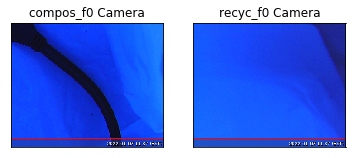

In [19]:





show_imgs()

In [121]:
img1, img2 = get_imgs()

# def images_diff(imgf, img0, thresh = 0):
    
#     f_shape = np.shape(imgf)
#     print(np.shape(imgf))
    
#     imgn_r = imgae_diff(imgf[:,:,0], img0[:,:,0], thresh)
#     imgn_g = imgae_diff(imgf[:,:,1], img0[:,:,1], thresh)
#     imgn_b = imgae_diff(imgf[:,:,2], img0[:,:,2], thresh)
    
#     print(np.shape(imgn_r))
    
#     imgn = np.dstack((imgn_b, imgn_g, imgn_r))
    
    
#     return imgn

def imgae_diff(imgf, img0, thresh = 0):
    imgf = np.array(imgf)
    img0 = np.array(img0)

    
    f_shape = np.shape(imgf)
    
    imgf_flatten = imgf.flatten()
    img0_flatten = img0.flatten()
    
    num_pixels_changed =  0
    
    for i in range(len(imgf_flatten)):
        if (imgf_flatten[i] >= img0_flatten[i]-thresh) and (imgf_flatten[i] <= img0_flatten[i]+thresh):
            imgf_flatten[i] = 255
        else:
            num_pixels_changed += 1
    return np.reshape(imgf_flatten, (f_shape)), num_pixels_changed

# img1 = cv2.imread('trash_f1.jpg') 
# img2 = cv2.imread('trash_f2.jpg') 
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


ff, pixelschanged = imgae_diff(img1, img2, 60)

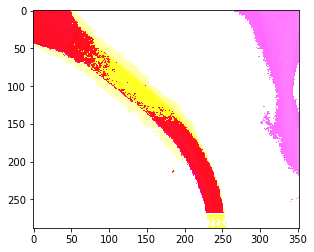

In [122]:
plt.imshow(ff)

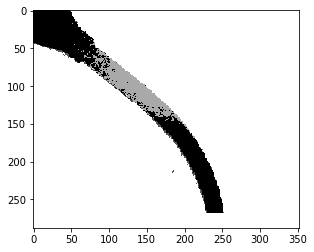

In [123]:
ret,mymask = cv2.threshold(ff,60,255,cv2.THRESH_BINARY)
mymask = cv2.cvtColor(mymask, cv2.COLOR_BGR2GRAY)

plt.imshow(mymask, cmap='gray')

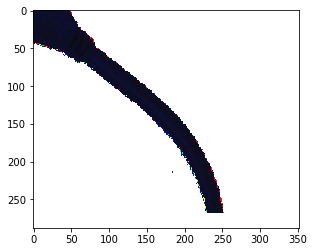

In [126]:
fg = cv2.bitwise_or(img1,img1,mask=255-mymask)
fg=fg+255
plt.imshow(fg)

In [127]:
dom = get_average_color(fg)
convert_rgb_to_name(dom)

74
Closest Match :  Black  with accuracy of  81.36120056734723 %


'plastic'